# Prerequisites

In [1]:
import sys

sys.path.append("..")

In [2]:
%load_ext autoreload
%autoreload 2

import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms.v2 as transforms
from skimage.io import imread
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision.models import resnet18
from tqdm.notebook import tqdm

import transforms3d as T
from dataset3d import BNSet
from model3d import CNN3d
from util3d import show_volume

In [3]:
data_dir = "../data/bugNIST_DATA"

name_legend = {
    "ac": "brown_cricket",
    "bc": "black_cricket",
    "bf": "blow_fly",
    "bl": "buffalo_bettle_larva",
    "bp": "blow_fly_pupa",
    "cf": "curly-wing_fly",
    "gh": "grasshopper",
    "ma": "maggot",
    "ml": "mealworm",
    "pp": "green_bottle_fly_pupa",
    "sl": "soldier_fly_larva",
    "wo": "woodlice",
}

device = "cuda" if torch.cuda.is_available() else "cpu"

# Transforms

In [4]:
transform = transforms.Compose(
    [
        T.ToTensor(),
        T.RandomAxisFlip(0),
        T.RandomAxisFlip(1),
        T.RandomAxisFlip(2),
        transforms.RandomApply([T.RollJitter((6, 3, 3), (-3, -2, -1))], p=0.5),
        transforms.RandomApply([T.RandomRotation((6, 6, 360))], p=0.2),
        transforms.RandomApply([T.IntensityJitter(0.1, 0.1)], p=0.3),
        transforms.ToDtype(torch.float32, scale=True)
    ]
)

dset = BNSet(data_dir, "train", transform=transform)

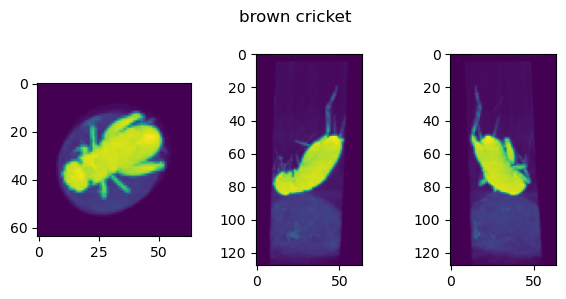

(tensor(0.), tensor(0.6471), 0.02180544)

In [5]:
volume, label = dset[0]
show_volume(volume[0].numpy(), label)
volume.min(), volume.max(), volume.numpy().mean()

# Multiprocessing

In [6]:
# batch_size = 16
# num_workers = 4

# dset = BNSet(data_dir, "train", transform=transform)
# dloader = DataLoader(dset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# for volumes, labels in tqdm(dloader):
#     pass

In [7]:
lr = 1e-4
batch_size = 16

num_workers = 8

subset = ["ac", "bc"]

model = CNN3d(len(subset))
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

dset = BNSet(data_dir, "train", subset=subset, transform=transform)
dloader = DataLoader(dset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [ ]:
model.train()

stats = {}
for epoch in range(50):
    metrics_train = {
        "loss": [],
        "preds": [],
        "labels": [],
    }

    print(f"Epoch {epoch}")
    for volumes, labels in tqdm(dloader):
        out = model(volumes.to(device))

        loss = criterion(out, labels.type(torch.LongTensor).to(device))
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        _, indices = torch.max(out.cpu(), 1)

        metrics_train["loss"].append(loss.cpu().detach().item())
        metrics_train["preds"].append(indices.detach().numpy())
        metrics_train["labels"].append(labels.numpy())

    performance = {
        "loss": np.mean(metrics_train["loss"]),
        "accuracy": np.mean(
            np.concatenate(metrics_train["preds"])
            == np.concatenate(metrics_train["labels"])
        ).item(),
    }
    print(performance)
    stats[epoch] = performance

Epoch 0


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.675689301824057, 'accuracy': 0.5932659932659933}
Epoch 1


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.6145171933276679, 'accuracy': 0.6828282828282828}
Epoch 2


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.5891165829473927, 'accuracy': 0.6909090909090909}
Epoch 3


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.5711033940315247, 'accuracy': 0.6989898989898989}
Epoch 4


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.5730093025392101, 'accuracy': 0.7131313131313132}
Epoch 5


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.5457485032978878, 'accuracy': 0.7232323232323232}
Epoch 6


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.5615513757351906, 'accuracy': 0.7185185185185186}
Epoch 7


  0%|          | 0/93 [00:00<?, ?it/s]

In [ ]:
dloader = DataLoader(dset, batch_size=1, shuffle=True)
model.eval();

In [ ]:
volumes, labels = next(iter(dloader))
out = model(volumes.to(device))

_, indices = torch.max(out.cpu(), 1)
pred = indices.item()

show_volume(volumes[0][0].numpy(), labels.item())
print(pred, labels.item())

In [ ]:
def get_saliency3d(model, volumes, device="cpu"):
    # Calculate gradient of higest score w.r.t. input
    volumes = Variable(volumes.data, requires_grad=True)

    # Get predictions (forward pass)
    out = model(volumes.to(device))
    score, indices = torch.max(out, 1)

    # Backward pass to get gradients of score predicted class w.r.t. input image
    score.backward()

    pred = indices.item()

    slc = volumes.grad[0].cpu().numpy()[0]

    return slc

In [ ]:
volumes, labels = next(iter(dloader))

slc = get_saliency3d(model, volumes, device=device)

slc_abs = np.abs(slc)
show_volume(volumes[0][0].detach().numpy(), labels.item())
show_volume(slc_abs / slc_abs.max(), cmap="inferno")
print(pred, labels.item())

In [ ]:
show_volume((volumes > volumes.float().quantile(0.95))[0][0].detach().numpy())